In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt

In [5]:
#load_data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
class_names = ['airplane','car','bird','cat','deer','dog','frog','horse','ship','truck']

In [6]:
#Create the imageDataGenerator for rescaling and avoiding overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=64)


In [7]:
def create_cnn_model(hp):
    model = Sequential()
    
    # Primer bloque
    model.add(Conv2D(filters=hp.Int('conv1_filters', 32, 64, step=16),
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same',
                     input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    
    # Segundo bloque
    model.add(Conv2D(filters=hp.Int('conv2_filters', 64, 128, step=32),
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))
    
    # Flatten y Dense final
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor='val_loss',  # también podrías usar 'val_accuracy'
    patience=5,          # espera 5 épocas sin mejora antes de parar
    restore_best_weights=True  # deja los pesos del mejor epoch
)
tuner = kt.Hyperband(
    create_cnn_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='keras_tuner',
    project_name='cifar10_cnn'
)

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[stop_early]
)



Reloading Tuner from keras_tuner\cifar10_cnn\tuner0.json


In [9]:
best_model=tuner.get_best_models()[0]
best_pam=tuner.get_best_hyperparameters()[0]
print(best_model)
print(best_pam)

C:\Users\Agonz\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>


C:\Users\Agonz\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
#build the model with the best params from scratch
model=tuner.hypermodel.build(best_pam)

In [12]:
#Train the best model
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100


C:\Users\Agonz\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.3592 - loss: 1.7916 - val_accuracy: 0.4719 - val_loss: 1.4301
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.4409 - loss: 1.5458 - val_accuracy: 0.5190 - val_loss: 1.3156
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.4810 - loss: 1.4468 - val_accuracy: 0.5242 - val_loss: 1.4041
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5075 - loss: 1.3730 - val_accuracy: 0.6094 - val_loss: 1.0878
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5290 - loss: 1.3127 - val_accuracy: 0.6174 - val_loss: 1.0592
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.5447 - loss: 1.2725 - val_accuracy: 0.5904 - val_loss: 1.1915
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.5589 - loss: 1.2411 - val_accuracy: 0.5760 - val_loss: 1.2446
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.5706 - loss: 1.2071 - val_

In [14]:
#Accuracy and loss
loss,acc=model.evaluate(validation_generator)
print(acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7787 - loss: 0.6491
0.7786999940872192


In [19]:
#predict the values
y_pred=model.predict(X_test/255)
print(y_pred)
y_predict = np.argmax(y_pred, axis=1)
print(y_predict)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[2.3920597e-04 8.2440826e-04 1.0007872e-03 ... 2.3522384e-04
  3.9930767e-03 1.9182606e-03]
 [6.0776336e-04 3.5403343e-03 3.9693023e-07 ... 5.8018408e-08
  9.9579418e-01 5.5996596e-05]
 [1.7939308e-03 2.6480982e-03 6.4950618e-05 ... 2.3649882e-05
  9.9448073e-01 8.9626084e-04]
 ...
 [1.6271393e-08 2.1274889e-06 4.6993059e-04 ... 3.8968495e-04
  1.9520117e-05 3.0835236e-05]
 [6.5764082e-03 9.6607369e-01 1.1936910e-03 ... 6.7758549e-04
  4.0509915e-03 1.9815968e-02]
 [3.8846537e-07 9.7834603e-09 1.0573485e-05 ... 9.9443924e-01
  7.9369183e-10 8.6958973e-09]]
[3 8 8 ... 5 1 7]


In [24]:
#obtein the real values
y_true = y_test.flatten()
print(y_true)

[3 8 8 ... 5 1 7]


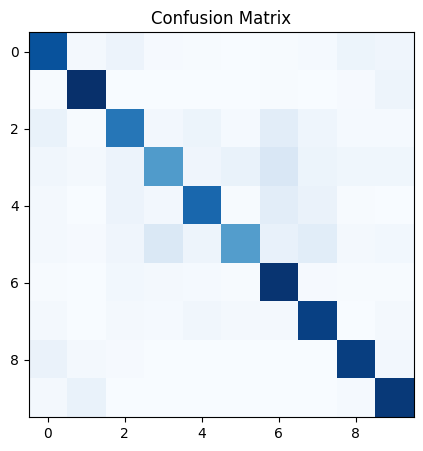

In [32]:
#Evaluate the model
cm=confusion_matrix(y_true,y_predict)
plt.figure(figsize=(5,5))
plt.imshow(cm,cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [39]:
#Same process with transfer learning
base_model=VGG16(include_top=False,input_shape=(32,32,3))
for layer in base_model.layers:
    layer.trainable=False

x=Flatten()(base_model.output)
x=Dense(256,activation="relu")(x)
x=Dropout(0.5)(x)
output=Dense(10,activation="softmax")(x)
vgg_model=Model(base_model.input,output)
vgg_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_vgg=vgg_model.fit(train_generator,epochs=50,validation_data=validation_generator)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 212s 270ms/step - accuracy: 0.3899 - loss: 1.7139 - val_accuracy: 0.5178 - val_loss: 1.3742
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 212s 271ms/step - accuracy: 0.4594 - loss: 1.5365 - val_accuracy: 0.5351 - val_loss: 1.3275
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.4688 - loss: 1.4990 - val_accuracy: 0.5397 - val_loss: 1.3035
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.4809 - loss: 1.4680 - val_accuracy: 0.5461 - val_loss: 1.2837
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.4875 - loss: 1.4572 - val_accuracy: 0.5540 - val_loss: 1.2549
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 154ms/step - accuracy: 0.4916 - loss: 1.4389 - val_accuracy: 0.5493 - val_loss: 1.2683
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 159ms/step - accuracy: 0.4962 - loss: 1.4330 - val_accuracy: 0.5496 - val_loss: 1.2689
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.4954 -

In [45]:
#fine-tunning
for layers in vgg_model.layers[-4:]:
    layers.trainable=True

vgg_model.compile(optimizer=Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
vgg_model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[stop_early])

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 187s 238ms/step - accuracy: 0.5412 - loss: 1.3044 - val_accuracy: 0.5973 - val_loss: 1.1503
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 142ms/step - accuracy: 0.5443 - loss: 1.3004 - val_accuracy: 0.5972 - val_loss: 1.1510
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 134ms/step - accuracy: 0.5471 - loss: 1.2935 - val_accuracy: 0.5981 - val_loss: 1.1497
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 112s 144ms/step - accuracy: 0.5437 - loss: 1.3028 - val_accuracy: 0.5983 - val_loss: 1.1505
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 149ms/step - accuracy: 0.5459 - loss: 1.2959 - val_accuracy: 0.5999 - val_loss: 1.1482
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 152ms/step - accuracy: 0.5443 - loss: 1.2997 - val_accuracy: 0.5991 - val_loss: 1.1487
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 159ms/step - accuracy: 0.5472 - loss: 1.2982 - val_accuracy: 0.5997 - val_loss: 1.1485
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 162ms/step - accuracy: 0.5469 -

In [53]:

print("VGG16",vgg_model.evaluate(validation_generator))
#VGG16 is better for larger images. With 32x32 CIFAR10 images, a custom CNN often outperforms pretrained networks.

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.6010 - loss: 1.1449
VGG16 [1.144911527633667, 0.6010000109672546]


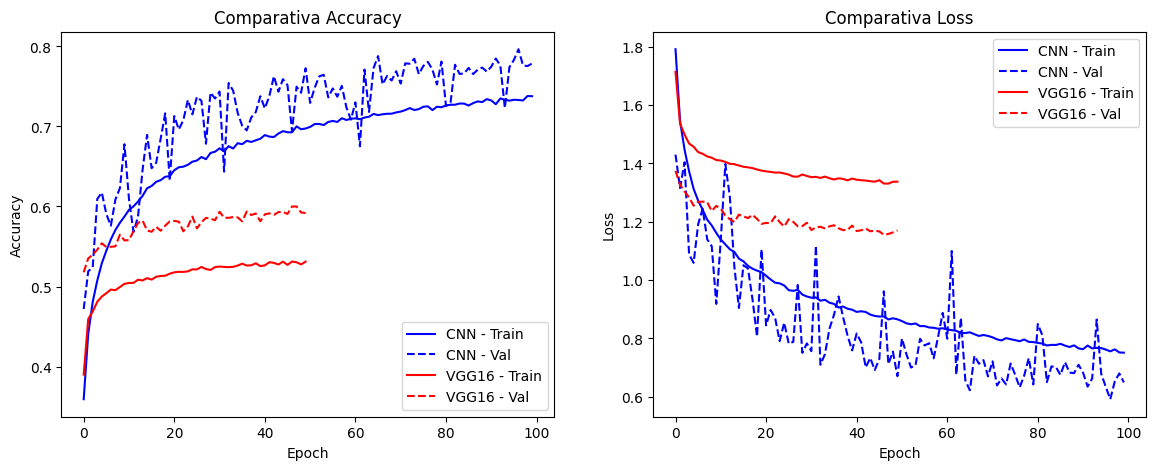

In [52]:
import matplotlib.pyplot as plt

# Curvas comparativas de Accuracy y Loss
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='CNN - Train', color='blue', linestyle='-')
plt.plot(history.history['val_accuracy'], label='CNN - Val', color='blue', linestyle='--')
plt.plot(history_vgg.history['accuracy'], label='VGG16 - Train', color='red', linestyle='-')
plt.plot(history_vgg.history['val_accuracy'], label='VGG16 - Val', color='red', linestyle='--')
plt.title('Comparativa Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='CNN - Train', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='CNN - Val', color='blue', linestyle='--')
plt.plot(history_vgg.history['loss'], label='VGG16 - Train', color='red', linestyle='-')
plt.plot(history_vgg.history['val_loss'], label='VGG16 - Val', color='red', linestyle='--')
plt.title('Comparativa Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
